## Split Population Exponential Fitness Function Simulations

In [1]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [44]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.process_sims import extract_runs, load_pickled, load_stats
from cvtk.process_sims import params_vary_over, col_palette, average_runs
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
DATADIR = "../data/sims_intermediate/split_exp/"
SIMDIR = "../data/sims/split_exp/"

In [6]:
converters = dict(N=int, alpha=float, nmu=float, rbp=float, tmu=float,
                  mag=float, Va=float, L = int,
                  region_length=int, sampleN=int, shifttime=int, tail=float)
expfit_results = load_pickled(DATADIR, converters=converters, add_in_Va=True)
expfit_stats_orig = load_stats(SIMDIR, converters=converters, add_in_Va=True)

In [7]:
# we didn't process covariances for all parameters (e.g. N=100 and rbp=5e-9 excluded for now)
# so we subset:
expfit_stats = defaultdict(list)
for key in expfit_results:
    expfit_stats[key].extend(expfit_stats_orig[key])

In [8]:
len(expfit_results.keys())

480

In [9]:
len(expfit_stats.keys())

480

In [10]:
assert(set(expfit_results.keys()) == set(expfit_stats.keys()))

## Response to Selection under Different Parameters

In [11]:
params_vary_over(expfit_results)

defaultdict(set,
            {'L': {1, 10, 100, 1000},
             'N': {1000},
             'Va': {0.0, 0.001, 0.002, 0.005, 0.01},
             'alpha': {0.0,
              0.00286,
              0.004044,
              0.006394,
              0.009043,
              0.01279,
              0.02022,
              0.0286,
              0.04044,
              0.06394,
              0.09043,
              0.1279,
              0.2022,
              0.286},
             'mag': {0.1, 1.0},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {50, 100, 200, 1000},
             'shifttime': {5},
             'shifttype': {'converge', 'diverge', 'single'},
             'tmu': {0.0, 6.114e-13, 6.114e-12, 6.114e-11, 6.114e-10}})

In [12]:
stats_subset = extract_runs({'mag': [1.0], 'sampleN': [1000], 'Va': [0.001, 0.005, 0.01],
                             'shifttype': ['converge'], 'L': [1, 100, 1000]},
                            expfit_stats)
subset_params = params_vary_over(stats_subset)
subset_params

defaultdict(set,
            {'L': {1, 100, 1000},
             'N': {1000},
             'Va': {0.001, 0.005, 0.01},
             'alpha': {0.00286,
              0.006394,
              0.009043,
              0.02022,
              0.0286,
              0.09043,
              0.2022,
              0.286},
             'mag': {1.0},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {1000},
             'shifttime': {5},
             'shifttype': {'converge'},
             'tmu': {6.114e-13, 6.114e-11, 6.114e-10}})

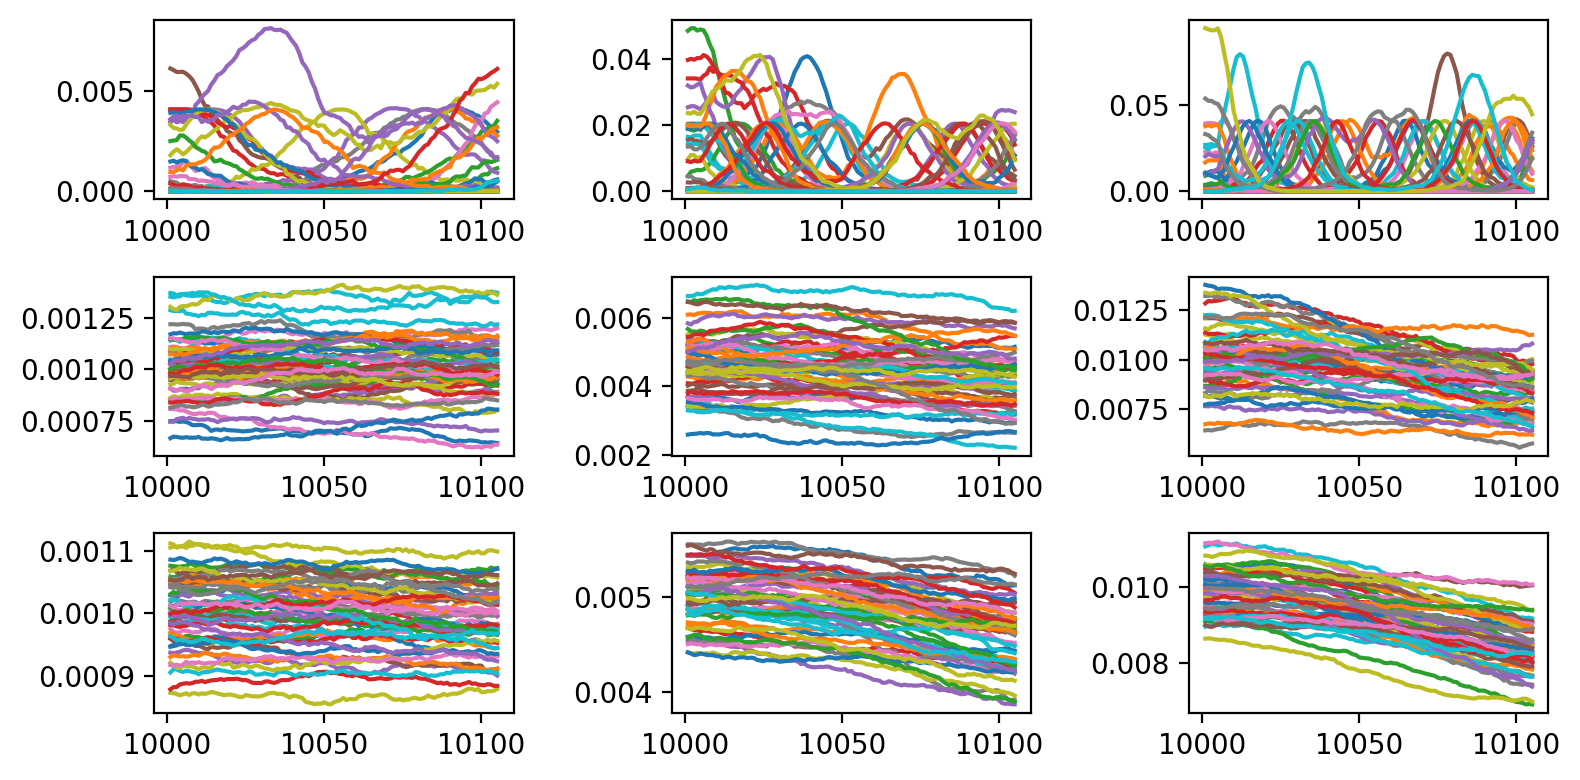

In [13]:
fix, ax = plt.subplots(nrows = 3, ncols=3)

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, stats_subset)
        assert(len(d.keys()) == 1)
        for run in list(d.values())[0]:
            ax[i, j].plot(run.generation, run.genic_va_1)
            
plt.tight_layout()

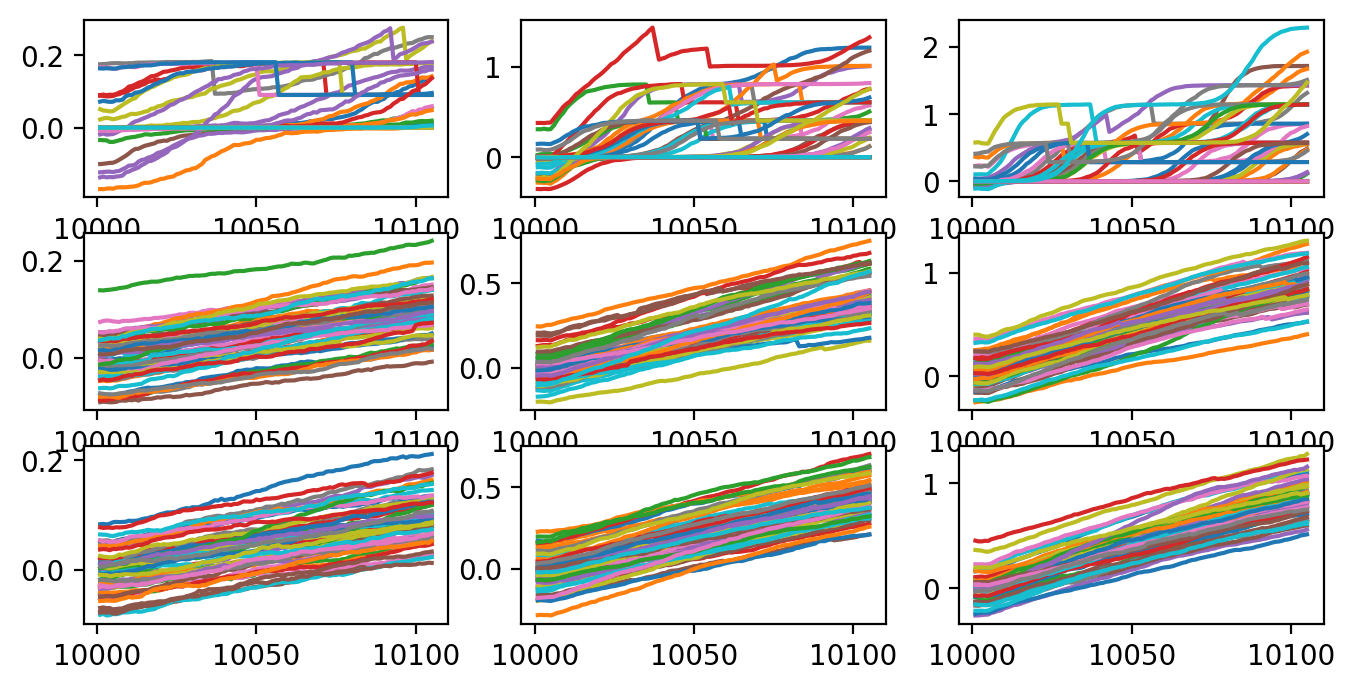

In [14]:
fix, ax = plt.subplots(nrows = 3, ncols=3)

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, stats_subset)
        assert(len(d.keys()) == 1)
        for run in list(d.values())[0]:
            ax[i, j].plot(run.generation, run.zbar_1)
    

## Covariances and G

In [15]:
covs_subset = extract_runs({'mag': [1.0], 'sampleN': [1000], 'Va': [0.001, 0.005, 0.01],
                             'shifttype': ['converge'], 'L': [1, 100, 1000]},
                              expfit_results)

### G

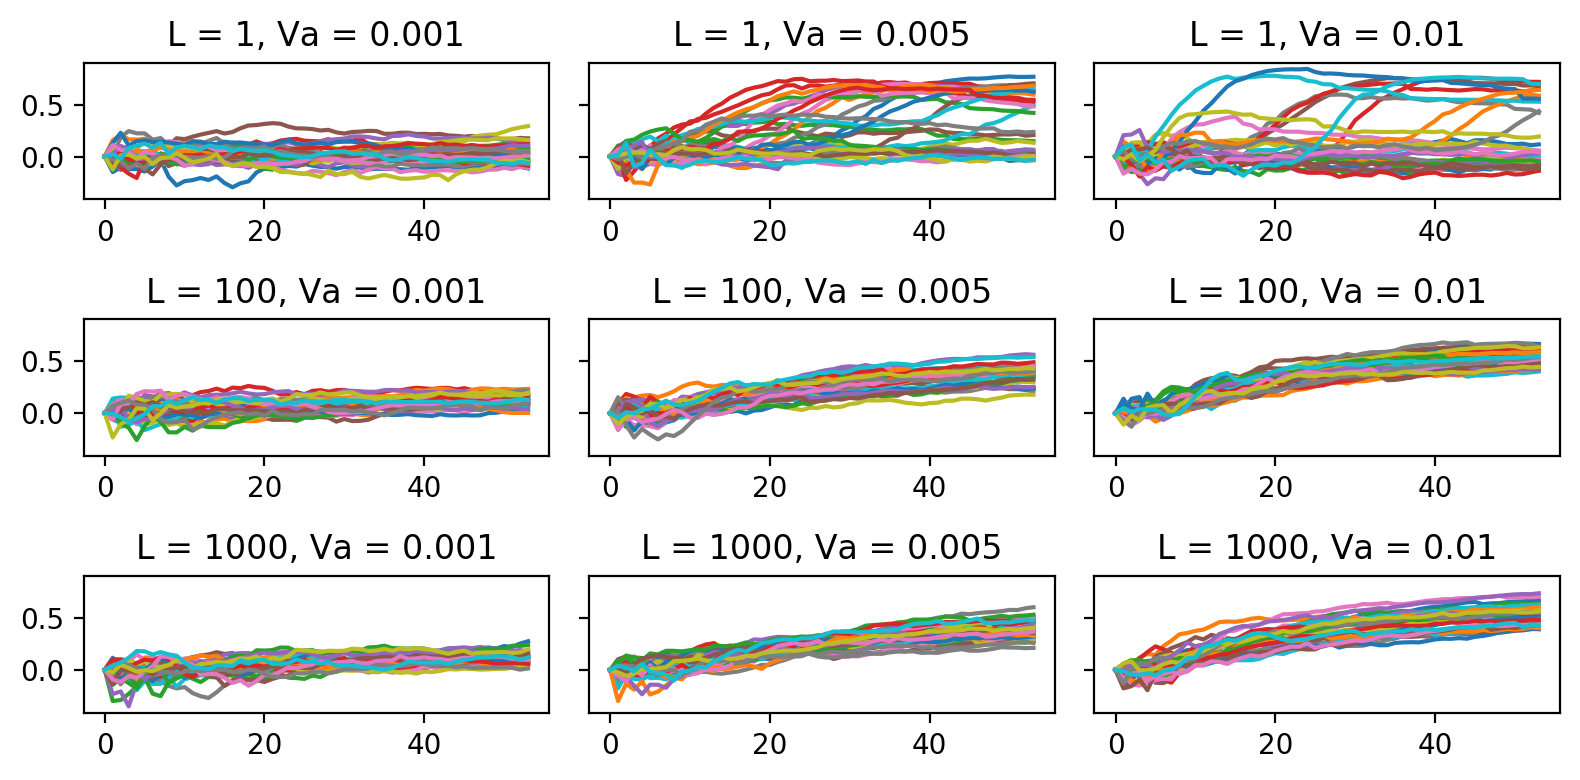

In [16]:
fix, ax = plt.subplots(nrows = 3, ncols=3, sharey=True)

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, covs_subset)
        assert(len(d.keys()) == 1)
        for run in list(d.values())[0]:
            ax[i, j].plot(run[1][:, 0])
            ax[i, j].set_title(f"L = {L}, Va = {Va}")
plt.tight_layout()

### Covariances

In [49]:
stacked_covs_subset = average_runs(covs_subset)

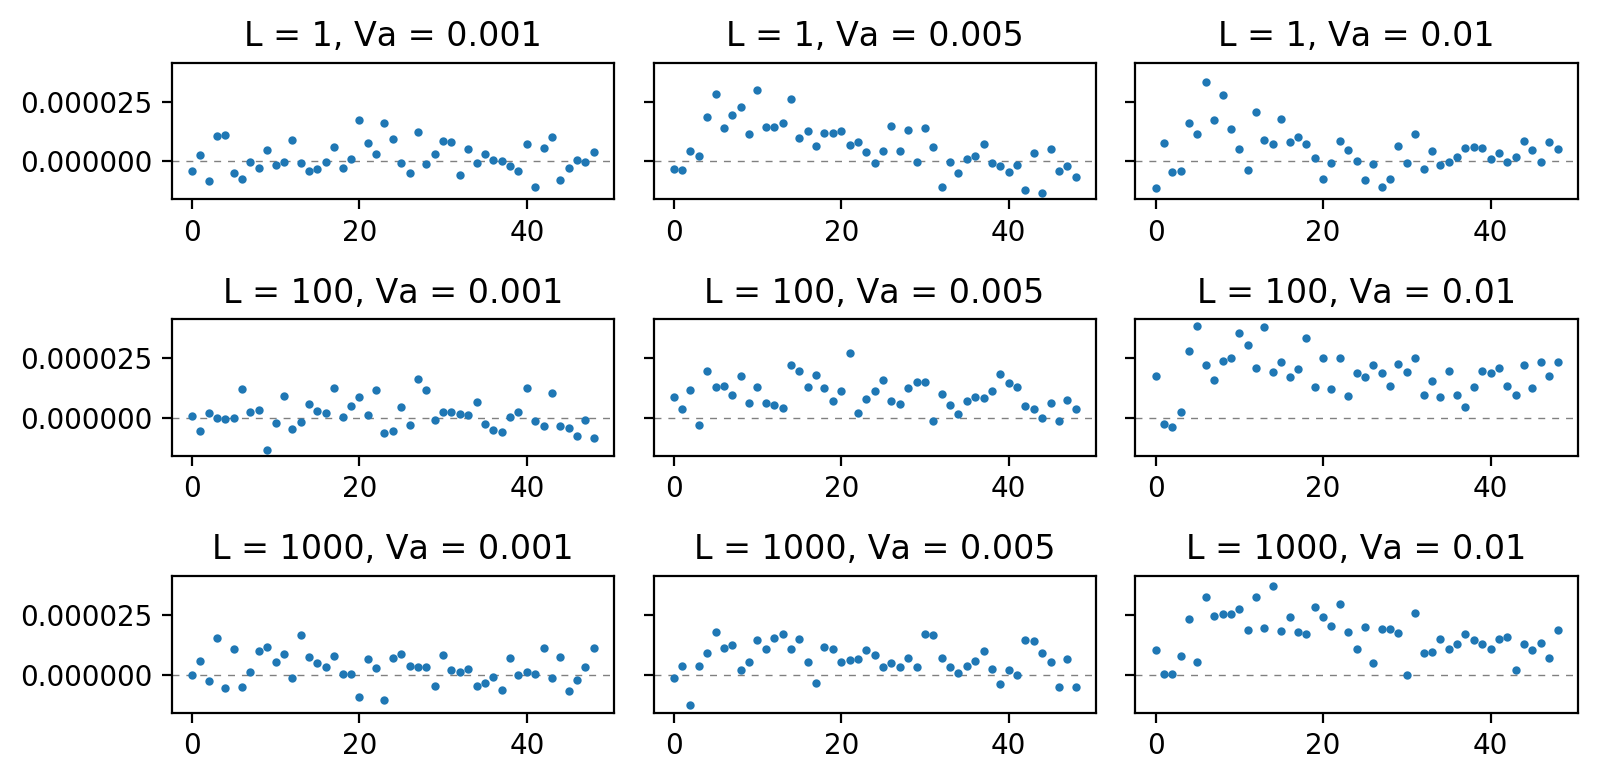

In [82]:
fix, ax = plt.subplots(nrows = 3, ncols=3, sharey=True)

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])


maxgen = 50
ref = 5

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, stacked_covs_subset)
        assert(len(d.keys()) == 1)
        # this essentially unnests the single element
        for run in list(d.values()):            
            tempcovs = stack_temporal_covariances(run[0].mean(axis=0), run[2][0], run[2][1])
            n = tempcovs[0].shape[0]
            idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
            ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
            ax[i, j].plot(tempcovs[ref, idx, 1], 'o', markersize=2)        
            ax[i, j].set_title(f"L = {L}, Va = {Va}")
plt.tight_layout()

## Convergent Correlations